In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [2]:

microsoft = pd.read_csv("MSFT.csv")



def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data

microsoft = paint(microsoft)

tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1


microsoft_tweets = explore(df_tweets, 'MSFT')

def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result


microsoft = make_stock(microsoft, microsoft_tweets).dropna()

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(microsoft,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[0.04234417 0.04364442 0.00474211]
 [0.04242888 0.05043731 0.05470602]
 [0.04767955 0.04941835 0.00969039]
 ...
 [1.         1.         0.04425965]
 [0.99610441 0.98836707 0.05532456]
 [0.97730358 0.9893011  0.07690457]]


In [4]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出一个值，即预测的closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1105 - val_loss: 0.0021
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0060 - val_loss: 0.0308
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014 - val_loss: 0.0086
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.7910e-04 - val_loss: 0.0027
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.3741e-04 - val_loss: 0.0016
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.8899e-04 - val_loss: 0.0019
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.4229e-04 - val_loss: 0.0015
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.2806e-04 - val_loss: 0.0011
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.5749e-04 - val_loss: 0.0016
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/ste

In [5]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

8792.10748591796 19703.878831049675


In [6]:
test_predict

array([[128.69298515, 128.46984456],
       [129.6022746 , 129.40274763],
       [130.63882022, 130.44590817],
       [131.59185155, 131.39141851],
       [132.45692051, 132.22436894],
       [133.33562229, 133.04844654],
       [134.16141152, 133.81154453],
       [134.91043601, 134.49351654],
       [135.56198259, 135.07151366],
       [136.21924413, 135.65438942],
       [136.87112854, 136.23357988],
       [137.50465754, 136.79814843],
       [138.03234735, 137.24459048],
       [138.52973807, 137.62356677],
       [139.00451532, 137.9808945 ],
       [139.14953571, 138.12002376],
       [139.22941833, 138.1815158 ],
       [139.31666282, 138.24773908],
       [139.39135131, 138.32503233],
       [139.52418872, 138.46833827],
       [139.6762613 , 138.63614977],
       [139.53549897, 138.4938336 ],
       [139.39474368, 138.38981658],
       [139.26172329, 138.27690568],
       [139.06172817, 138.09340529],
       [138.90115355, 137.9528721 ],
       [138.70626107, 137.76400168],
 

In [7]:
train_predict

array([[ 57.53555099,  57.61273479],
       [ 57.93355295,  57.99625981],
       [ 58.25801539,  58.28343151],
       [ 58.52649665,  58.50216172],
       [ 58.75540963,  58.69595993],
       [ 58.93189039,  58.8404013 ],
       [ 59.05299174,  58.9287031 ],
       [ 59.15403094,  59.03365373],
       [ 59.18889777,  59.07099821],
       [ 59.18092006,  59.04688224],
       [ 59.15737053,  59.00509081],
       [ 59.13029137,  58.96041783],
       [ 59.1000134 ,  58.92014967],
       [ 59.13976116,  58.9635521 ],
       [ 59.25442263,  59.08434079],
       [ 59.41684124,  59.264112  ],
       [ 59.58577363,  59.4573346 ],
       [ 59.78409719,  59.70359759],
       [ 59.97270815,  59.91635409],
       [ 60.1822012 ,  60.12915271],
       [ 60.39961741,  60.34166878],
       [ 60.62084828,  60.55943555],
       [ 60.82391202,  60.75843004],
       [ 61.03902325,  60.97368553],
       [ 61.31622298,  61.24490159],
       [ 61.62000039,  61.54484903],
       [ 61.93737017,  61.87870835],
 

In [8]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [9]:
open_predict.shape

(467,)

Text(0.5, 1.0, 'Stock Price Prediction')

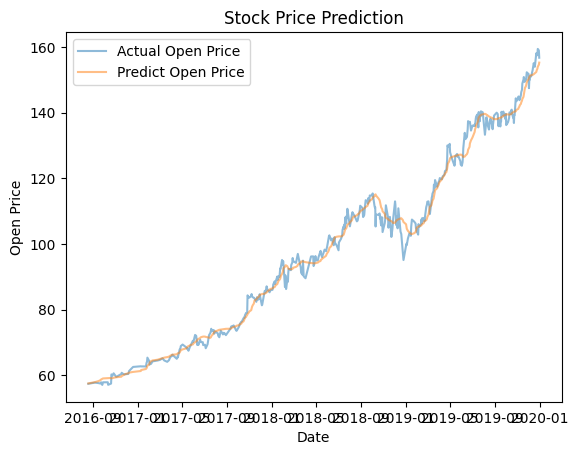

In [10]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

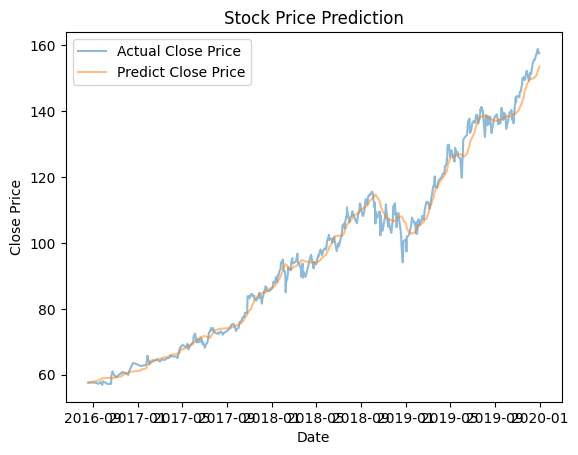

In [11]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [12]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,57.535551,57.612735
1,57.933553,57.996260
2,58.258015,58.283432
3,58.526497,58.502162
4,58.755410,58.695960
...,...,...
462,152.916133,151.286565
463,153.424539,151.813333
464,154.003579,152.398392
465,154.651761,153.040745


In [13]:
microsoft = microsoft[time_step:]
microsoft.reset_index(inplace=True)
microsoft_stock = pd.concat([microsoft, prediction], axis=1)
microsoft_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close
0,411,2016-08-19,17271000,57.430000,57.730000,57.200001,57.619999,53.930923,784.2,57.535551,57.612735
1,422,2016-09-06,16278400,57.779999,57.799999,57.209999,57.610001,53.921570,57.8,57.933553,57.996260
2,430,2016-09-16,44607000,57.630001,57.630001,56.750000,57.250000,53.584614,60.0,58.258015,58.283432
3,433,2016-09-21,33707300,57.509998,57.849998,57.080002,57.759998,54.061954,535.2,58.526497,58.502162
4,435,2016-09-23,19955300,57.869999,57.910000,57.380001,57.430000,53.753082,238.8,58.755410,58.695960
...,...,...,...,...,...,...,...,...,...,...,...
462,1253,2019-12-24,8989200,157.479996,157.710007,157.119995,157.380005,156.515396,50.4,152.916133,151.286565
463,1254,2019-12-26,14520600,157.559998,158.729996,157.399994,158.669998,157.798309,194.4,153.424539,151.813333
464,1255,2019-12-27,18412800,159.449997,159.550003,158.220001,158.960007,158.086731,307.6,154.003579,152.398392
465,1256,2019-12-30,16348400,158.990005,159.020004,156.729996,157.589996,156.724243,372.0,154.651761,153.040745


In [14]:
microsoft_stock['pre_Label'] = np.where(microsoft_stock['pre_close'].shift(-1) > microsoft_stock['pre_close'], 1, 0)
microsoft_stock['Label'] = np.where(microsoft_stock['close'].shift(-1) > microsoft_stock['close'], 1, 0)
microsoft_stock.dropna(inplace=True)

In [15]:
microsoft_stock

,index,date,volume,open,high,low,close,adj close,tweet_score,pre_open,pre_close,pre_Label,Label
0,411,2016-08-19,17271000,57.430000,57.730000,57.200001,57.619999,53.930923,784.2,57.535551,57.612735,1,0
1,422,2016-09-06,16278400,57.779999,57.799999,57.209999,57.610001,53.921570,57.8,57.933553,57.996260,1,0
2,430,2016-09-16,44607000,57.630001,57.630001,56.750000,57.250000,53.584614,60.0,58.258015,58.283432,1,1
3,433,2016-09-21,33707300,57.509998,57.849998,57.080002,57.759998,54.061954,535.2,58.526497,58.502162,1,0
4,435,2016-09-23,19955300,57.869999,57.910000,57.380001,57.430000,53.753082,238.8,58.755410,58.695960,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1253,2019-12-24,8989200,157.479996,157.710007,157.119995,157.380005,156.515396,50.4,152.916133,151.286565,1,1
463,1254,2019-12-26,14520600,157.559998,158.729996,157.399994,158.669998,157.798309,194.4,153.424539,151.813333,1,1
464,1255,2019-12-27,18412800,159.449997,159.550003,158.220001,158.960007,158.086731,307.6,154.003579,152.398392,1,0
465,1256,2019-12-30,16348400,158.990005,159.020004,156.729996,157.589996,156.724243,372.0,154.651761,153.040745,1,1


In [16]:
TP = ((microsoft_stock['Label'] == 1) & (microsoft_stock['pre_Label'] == 1)).sum()
FP = ((microsoft_stock['Label'] == 0) & (microsoft_stock['pre_Label'] == 1)).sum()
FN = ((microsoft_stock['Label'] == 1) & (microsoft_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5820512820512821 0.822463768115942 0.6816816816816818


In [17]:
initial_fund = 10000
funds = initial_fund
for index in range(len(microsoft_stock) - 1):
    if microsoft_stock.loc[index, 'pre_Label'] == 1:
        # 在下一行的open买入股票
        funds += (microsoft_stock.loc[index + 1, 'close'] - microsoft_stock.loc[index + 1, 'open'])
print(funds)

10003.490013122559


In [18]:
X = []
y = []
for i in range(len(scaled_data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 0.1337 - val_loss: 0.0015
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0070 - val_loss: 0.0382
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0022 - val_loss: 0.0119
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.1248e-04 - val_loss: 0.0020
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 9.8036e-04 - val_loss: 0.0022
Epoch 10/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.4850e-04 - val_loss: 0.0012
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/ste

In [19]:
predictions = pd.DataFrame(predictions, columns=['pred'])
num = len(microsoft) - len(predictions)
df = microsoft[num:]
df.reset_index(inplace=True)
df
stock1 = pd.concat([df, predictions], axis=1)
stock1
stock1['pre_Label'] = np.where(stock1['pred'].shift(-1) > stock1['pred'], 1, 0)
stock1['Label'] = np.where(stock1['close'].shift(-1) > stock1['close'], 1, 0)
TP = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 1)).sum()
FP = ((stock1['Label'] == 0) & (stock1['pre_Label'] == 1)).sum()
FN = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(round(precision,3), round(recall,3), round(f1,3))

0.662 0.782 0.717
